**Training EfficientNetB4 Model from ImageNet Weights**

This is an example of training the model from ImageNet weights, first using a balanced training set without cutmix, then a balanced training set with cutmix. The final model was trained more extensively than shown in this notebook, but using the same methods. 

I start by cloning my github repository which contains the model classes, and copying the image files from Google Drive onto the GPU.

In [ ]:
#get repo from github
!git clone https://github.com/melanierbutler/cassava.git

#install cutmix for keras
!pip install cutmix-keras

#get image files from google drive
from google.colab import drive
drive.mount('/gdrive')

data_path = '/gdrive/MyDrive/colab_projects/cassava/cassava_data/'
!cp -r '{data_path}' /content/cassava/data/
!unzip -q /content/cassava/data/cassava_data/\*.zip -d /content/cassava/data/

#add to path
import sys
sys.path.append('/content/cassava/src/')

Cloning into 'cassava'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 63 (delta 17), reused 55 (delta 12), pack-reused 0
Unpacking objects: 100% (63/63), done.
Mounted at /gdrive

2 archives were successfully processed.


In [ ]:
#import classes
from preprocessing import *
from cnn_utils import *
from model import *

In [ ]:
#define training and save paths and read in training csv and label key
train_dir = '/content/cassava/data/train_images/'
df = pd.read_csv('/content/cassava/data/train.csv')
label_key = pd.read_json('/content/cassava/data/label_num_to_disease_map.json', typ='series')
save_dir = '/gdrive/MyDrive/colab_projects/cassava/models/'

In [ ]:
#instantiate the ImageFromDFLoader class
dl = ImageFromDFLoader(df, label_key, train_dir, balanced=True)

Found 8500 validated image filenames belonging to 5 classes.
Found 1500 validated image filenames belonging to 5 classes.
Found 1500 validated image filenames belonging to 5 classes.


For more details on the augmentation methods chose for the ImageFromDFLoader class please see the cassava_wrangling_eda_engineering notebook. Here I will just visualize a few batches.

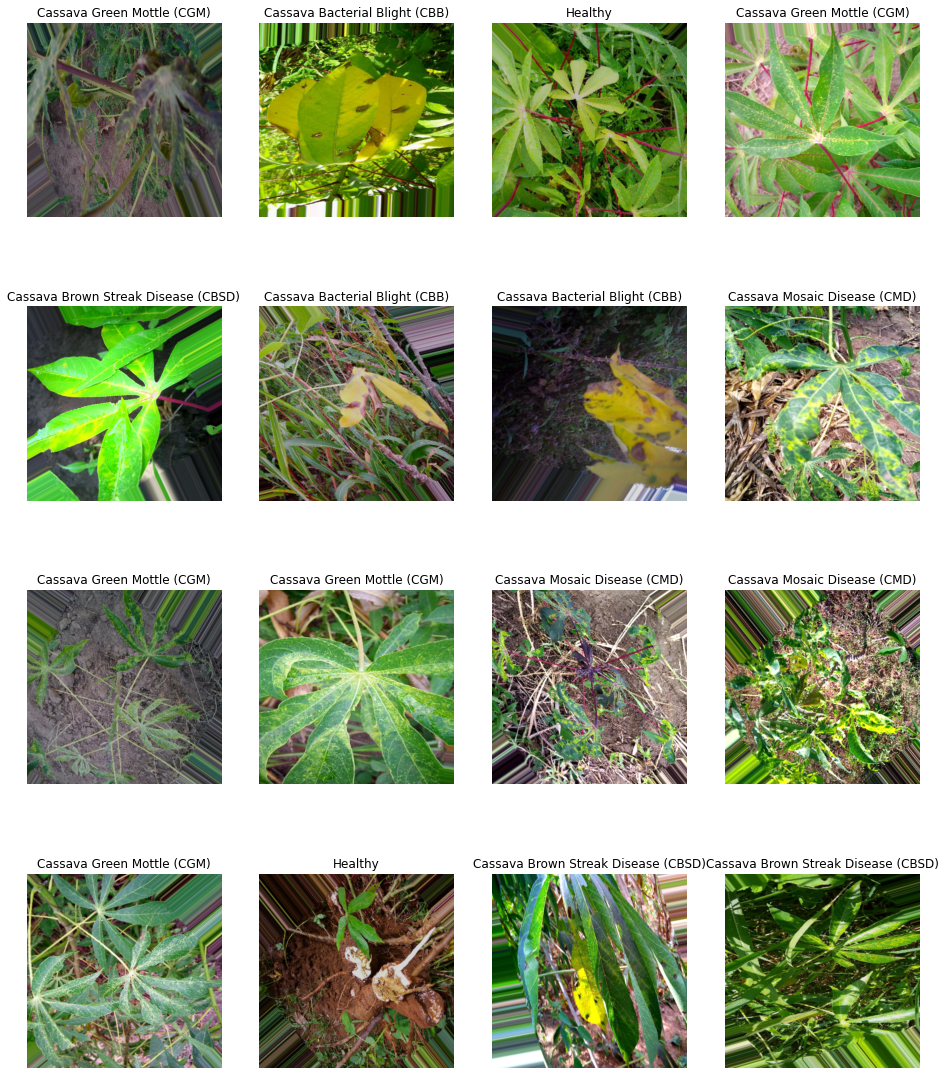

In [ ]:
dl.plot_train_batch()

For the initial training I froze the first two blocks of the EfficientNetB4 architecture. This preserves the initial ImageNet weights of the earliest, lowest-complexity features and forces the optimization of more complex compound features to begin with. 

In [ ]:
model = EfficientNetB4Model()
model.freeze_up_to_block('3')
model.compile_model()

Building new model.
First 88 layers frozen.


In [ ]:
model.train(data_loader=dl, epochs=10)

Epoch 1/10
531/531 [==============================] - 495s 901ms/step - loss: 1.4631 - acc: 0.3485 - val_loss: 1.4207 - val_acc: 0.3770

Epoch 00001: val_loss improved from inf to 1.42072, saving model to Model
Epoch 2/10
531/531 [==============================] - 476s 896ms/step - loss: 1.2113 - acc: 0.4993 - val_loss: 1.2410 - val_acc: 0.4832

Epoch 00002: val_loss improved from 1.42072 to 1.24096, saving model to Model
Epoch 3/10
531/531 [==============================] - 474s 892ms/step - loss: 1.1168 - acc: 0.5438 - val_loss: 1.1894 - val_acc: 0.5242

Epoch 00003: val_loss improved from 1.24096 to 1.18940, saving model to Model
Epoch 4/10
531/531 [==============================] - 473s 890ms/step - loss: 1.0610 - acc: 0.5670 - val_loss: 1.1697 - val_acc: 0.5202

Epoch 00004: val_loss improved from 1.18940 to 1.16971, saving model to Model
Epoch 5/10
531/531 [==============================] - 467s 880ms/step - loss: 0.9961 - acc: 0.6003 - val_loss: 1.0786 - val_acc: 0.5538

Epoch 0

Originally the model was trained with the first two layers frozen until both the training and validation losses were in the range of 0.4 to 0.7. This originally took twenty epochs. Here I am only showing ten of those cycles.

Model saved to /gdrive/MyDrive/colab_projects/cassava/models/efficientNetB4.h5


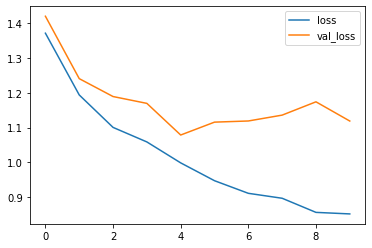

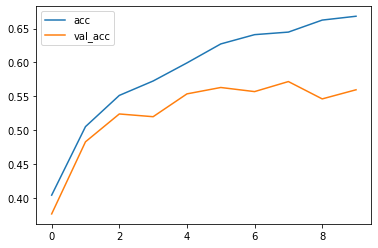

In [ ]:
model.save_to_disk(save_dir, 'efficientNetB4.h5')
model.plot_history()

The earlier layers were then unfrozen and the Dropout rate of the final penultimate layer set to 0.3. The model was trained for a further ten epochs on the balanced, non-cutmix training set. Once the validation loss was consistently in the 0.35 to 0.45 range the model was then trained on images generated using cutmix. Only a sample of this is shown below. The loss jumps initially with the introduction of the cutmix training set as expected, since the model is now encountering ground truths that are mixtures of multiple classes. 

In [ ]:
dl_cutmix = ImageFromDFLoader(df, label_key, train_dir, balanced=True, cutmix=True)

Found 8500 validated image filenames belonging to 5 classes.
Found 8500 validated image filenames belonging to 5 classes.
Found 1500 validated image filenames belonging to 5 classes.
Found 1500 validated image filenames belonging to 5 classes.


In [ ]:
dl_cutmix.plot_train_batch()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
model.train(data_loader=dl_cutmix, epochs=3)

Epoch 1/3
531/531 [==============================] - 901s 2s/step - loss: 1.3224 - acc: 0.5219 - val_loss: 1.1358 - val_acc: 0.5276

Epoch 00001: val_loss did not improve from 1.07855
Epoch 2/3
531/531 [==============================] - 898s 2s/step - loss: 1.2694 - acc: 0.5335 - val_loss: 1.1310 - val_acc: 0.5397

Epoch 00002: val_loss did not improve from 1.07855
Epoch 3/3
531/531 [==============================] - 882s 2s/step - loss: 1.2707 - acc: 0.5376 - val_loss: 1.1050 - val_acc: 0.5753

Epoch 00003: val_loss did not improve from 1.07855


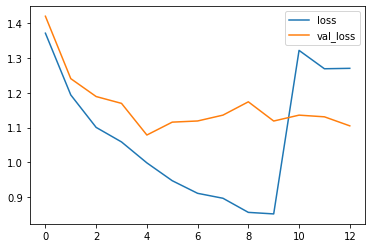

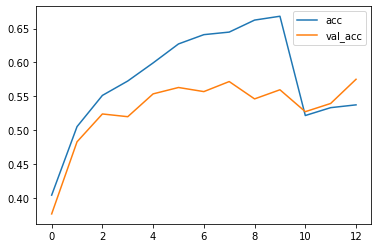

In [ ]:
model.plot_history()

The dropout rate of the penultimate layer was set to 0.1 and the model was trained for 30 more epochs on balanced cutmix data, although it began to plateau in performance after around 20 epochs. Finally, the model was trained on the full, unbalanced data set using cutmix for 25 epochs. The training and valication losses plateaued at 0.5 and 0.4, respectively. The final training and validation accuracies were both about 0.88.